# Homework 3

In [587]:
import folium
import pandas as pd
import numpy as np
import json
import os
from folium.features import TopoJson
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

**TODO : **
- **export folium to HTML and link them in your notebook**
- **add the real swisss unemployment rate for comparison in question 1**
- ** See whether to add unemployment rates for non EU european countries**
- **Answer the questions**
- **Add interactivity**
- **DO the visualisation**
- **FIX SCALE FOR MAPS WHICH ARE COMPARED : HAVE THE SAME FOR BOTH**
- ADD STRING TO TOOLTIP

## Question 1: unemployment rate in Europe

### Definitions
In order for our analysis to be meaningful we need to be clear about what we are talking about. Taking the definitions given in the Eurostat website we will consider the following : 

**Unemployed persons** are all persons 15 to 74 years of age (16 to 74 years in ES, IT and the UK) who were not employed during the reference week, had actively sought work during the past four weeks and were ready to begin working immediately or within two weeks. Figures show the number of persons unemployed in thousands.

**Employed persons** are all persons who worked at least one hour for pay or profit during the reference week or were temporarily absent from such work. For the unemployment rate, only persons from 15 to 74 years of age are used.

The **unemployment rate** is the number of people unemployed as a percentage of the labour force. The labour force is the total number of people employed and unemployed. In the database, unemployment rates can be downloaded by chosing the unit "PC_ACT", Percentage of Active Population.

The dataset that we used was http://ec.europa.eu/eurostat/web/products-datasets/-/ei_lmhr_m which contains monthly data of the unemployment rate of each country.

In the dataset we have values of unemployment rate considering 3 different categories: 
- age : over and above 25 
- gender : male or female
- all 

Therefore, we grouped the unemployment rates by the different values of the indicator selecting only the most recent information. 

In [249]:
# Recovering the indicators of the country from another csv file
file_path = r'ei_lmhr_m_1_Data.csv'
# Loading the data in the dataframe
country_df = pd.read_csv(file_path)

country_df = country_df[['GEO', 'GEO_LABEL']]
country_df.GEO_LABEL = country_df.GEO_LABEL.str.replace(" \(until 1990 former territory of the FRG\)", "")
country_df.set_index("GEO_LABEL", inplace = True)

GEO_Labels = country_df.to_dict()['GEO']

# Correcting erroneous country codes
GEO_Labels["United Kingdom"]= "GB"
GEO_Labels["Greece"]= "GR"

# Adding missing countries manually to the mapping with official country codes
# http://www.nationsonline.org/oneworld/country_code_list.htm

GEO_Labels.update({"Swizerland":"CH"})
GEO_Labels.update({"Russia":"RU"})
GEO_Labels.update({"Albania":"AL"})
GEO_Labels.update({"Macedonia":"MK"})
GEO_Labels.update({"Montenegro":"ME"})
GEO_Labels.update({"Belarus":"BY"})
GEO_Labels.update({"Bosnia and Herzegovina":"BA"})
GEO_Labels.update({"Ukraine":"UA"})
print(GEO_Labels)

{'Belgium': 'BE', 'Bulgaria': 'BG', 'Czech Republic': 'CZ', 'Denmark': 'DK', 'Germany': 'DE', 'Estonia': 'EE', 'Ireland': 'IE', 'Greece': 'GR', 'Spain': 'ES', 'France': 'FR', 'Croatia': 'HR', 'Italy': 'IT', 'Cyprus': 'CY', 'Latvia': 'LV', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Hungary': 'HU', 'Malta': 'MT', 'Netherlands': 'NL', 'Austria': 'AT', 'Poland': 'PL', 'Portugal': 'PT', 'Romania': 'RO', 'Slovenia': 'SI', 'Slovakia': 'SK', 'Finland': 'FI', 'Sweden': 'SE', 'United Kingdom': 'GB', 'Iceland': 'IS', 'Norway': 'NO', 'Turkey': 'TR', 'Swizerland': 'CH', 'Russia': 'RU', 'Albania': 'AL', 'Macedonia': 'MK', 'Montenegro': 'ME', 'Belarus': 'BY', 'Bosnia and Herzegovina': 'BA', 'Ukraine': 'UA'}


In [280]:
file_path = r'une_rt_a_1_Data.csv'
# Loading the data in the dataframe
EU_unemployment_df = pd.read_csv(file_path)
# Selecting values of people between 15 and 74 years
EU_unemployment_df.drop(["AGE", "Flag and Footnotes", "SEX"], axis = 1, inplace = True)

# Selecting most recent data
EU_unemployment_df = EU_unemployment_df.loc[EU_unemployment_df.TIME == 2016] # lack data for more recent months
EU_unemployment_df = EU_unemployment_df.loc[EU_unemployment_df.UNIT=='Percentage of active population']

# Retaining relevant information
EU_unemployment_df = EU_unemployment_df[['GEO', 'Value']]
EU_unemployment_df.set_index("GEO", inplace = True)
EU_unemployment_df.drop(["United States", "Japan"], inplace = True)
EU_unemployment_df.reset_index(inplace = True)
EU_unemployment_df.drop(EU_unemployment_df.GEO.str.contains("Euro"), inplace = True)



# Converting values to numeric values
EU_unemployment_df.GEO = EU_unemployment_df.GEO.str.replace(" \(until 1990 former territory of the FRG\)", "")

print(len(EU_unemployment_df))
EU_unemployment_df = EU_unemployment_df[~EU_unemployment_df['GEO'].str.contains("Eur")]
EU_unemployment_df["GEO_LABEL"] = EU_unemployment_df["GEO"].map(lambda x: GEO_Labels[x])

EU_unemployment_df.Value = pd.to_numeric(EU_unemployment_df.Value)
EU_unemployment_df.set_index("GEO", inplace = True)

# Adding missing unemployment rates manually for 2016
# Country codes recovered from here : http://www.nationsonline.org/oneworld/country_code_list.htm
EU_unemployment_df.loc["Swizerland"] = [3.3, "CH"]
EU_unemployment_df.loc["Russia"] = [np.nan, "RU"]
EU_unemployment_df.loc["Albania"] = [np.nan, "AL"]
EU_unemployment_df.loc["Macedonia"] = [np.nan, "MK"]
EU_unemployment_df.loc["Montenegro"] = [np.nan, "ME"]
EU_unemployment_df.loc["Ukraine"] = [np.nan, "UA"]
EU_unemployment_df.loc["Belarus"] = [np.nan, "BY"]
EU_unemployment_df.loc["Bosnia and Herzegovina"] = [np.nan, "BA"]

# Computing the differences in unemployment compared to Switzerland
EU_unemployment_df["Relative To Switzerland"] = EU_unemployment_df["Value"]- EU_unemployment_df.loc["Swizerland"].Value
EU_unemployment_df

35


,Value,GEO_LABEL,Relative To Switzerland
GEO,,,
Belgium,7.8,BE,4.5
Bulgaria,7.6,BG,4.3
Czech Republic,4.0,CZ,0.7
Denmark,6.2,DK,2.9
Germany,4.1,DE,0.8
Estonia,6.8,EE,3.5
Ireland,7.9,IE,4.6
Greece,23.6,GR,20.3
Spain,19.6,ES,16.3


It was asked to consider recent data. To avoid seasonal trends we averaged the data over an entire year. For simplicity we stuck to the annual averages from 2016 which were recovered here : http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=une_rt_a&lang=en

Before doing the plots we need to take into account:
- the number of variables 
- color and scale
- data classification method
- the interactivity we could add

We used a sequential color palette as we are only representing one variable. The thresholds / bins were selected based on the quartiles. The scale was selected in order to have 5 levels, each one containing 20% of the countries

**BLABLABLA**

http://jeffpaine.github.io/geojson-topojson/ 

In [626]:
bins = EU_unemployment_df.quantile([0.2*i for i in range(6)])
bins = bins['Value'].tolist()

EU_coordinates = [53.5775, 23.106111]
EU_map = folium.Map(location=EU_coordinates, tiles='cartodbpositron', zoom_start=4)
countries_geo = os.path.join('topojson', 'europe.topojson.json')
geo_json_data = json.load(open(countries_geo))


EU_map.choropleth(geo_data=geo_json_data, topojson= "objects.europe", data=EU_unemployment_df,
             columns=['GEO_LABEL', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment rate within the active population',
             threshold_scale = bins,
             highlight = True)

countries_geo = os.path.join('topojson', 'europe.geojson.json')
geo_json_data = json.load(open(countries_geo))

def style_function(feature):
    return {
        'weight': 0,
        'dashArray': '5, 5'
    }

inverted_dict = dict([[v,k] for k,v in GEO_Labels.items()])

for feature in geo_json_data['features']:
    try:        
        string = "Country : "+ inverted_dict[feature['id']] \
                + "\nUnemployment Rate :"
    except:
        None
    folium.GeoJson(
       feature,
        style_function=style_function,
    ).add_child(folium.Popup(string)).add_to(EU_map)
        
EU_map

#### Comparison with Switzerland

In [282]:
from folium import StepColormap
from branca.utilities import color_brewer 

bins = EU_unemployment_df[["Relative To Switzerland"]].quantile([0.2*i for i in range(6)])
bins = bins['Relative To Switzerland'].tolist()

EU_coordinates = [53.5775, 23.106111]
EU_map = folium.Map(location=EU_coordinates, tiles='cartodbpositron', zoom_start=4)
countries_geo = os.path.join('topojson', 'europe.topojson.json')
geo_json_data = json.load(open(countries_geo))


EU_map.choropleth(geo_data=geo_json_data, topojson= "objects.europe", data=EU_unemployment_df,
             columns=['GEO_LABEL', 'Relative To Switzerland'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment rate within the active population',
             threshold_scale = bins,
             highlight = True)
        
EU_map

**TODO : COMMENT**

## Question 2: Unemployment Rates In Switzerland

We need to analyze the different unemployment rates by considering the different cantons, age groups and foreigners vs. swiss.

Therefore we want to extract : 
    - unemployment rate of different cantons in CH 15-74 years (question 2)
    - unemployment rate of different cantons in CH 15-74 years making a distinction between *Swiss* and *foreign* (question 3) 
    - unemployment rate of different cantons in CH taking differences between age groups (question 3)

### Total Unemployment rate

In [494]:
# Dataframe to recover the information necessary to do the 
# visualizations at the level of the cantons 
df_geolabel = pd.read_csv('DictCantonGeo.csv',sep=';', encoding='utf-8')

# Function to fix loading issues with dataframe 
# Splitting dataframe based on columns
def split_comma_df(df):
    col_names = df.columns[0]
    col_names = col_names.replace("\"", "").replace("\'", "").split(",")
    df.columns = [0]
    df[0] = df[0].str.replace("\"", "").replace("\'", "")
    df = df[0].str.split(',', expand=True)
    # Recovering column names
    df.columns = col_names
    return df

file_path = r'chomage_total.csv'
df_CH = pd.read_csv(file_path, encoding='utf-16', sep = ",")  
df_CH = split_comma_df(df_CH)
# Selecting columns!
df_CH = df_CH[["Canton", "durchschnittliche Anzahl Arbeitslose", "Taux de chômage (1 cav)"]]
df_CH.columns = ["Canton", "Number Of Unemployed People",'Total', 'Au dessus de 50 ans']
# Computing Active Population Per Canton (for question 3)
df_CH.Total = pd.to_numeric(df_CH.Total)
df_CH['Number Of Unemployed People'] = df_CH['Number Of Unemployed People'].apply(str.replace, args=("'", ""))
df_CH['Number Of Unemployed People'] = pd.to_numeric(df_CH['Number Of Unemployed People'])
df_CH['Active Population'] = 100*df_CH['Number Of Unemployed People']/df_CH["Total"]
df_CH['Active Population'] = df_CH['Active Population'].apply(lambda x: int(np.ceil(x)))
# Convert values to numeric

df_CH = pd.merge(df_CH,df_geolabel,on='Canton', how='outer')
df_CH.set_index("Canton", inplace = True)
df_CH.head()

,Number Of Unemployed People,Total,Au dessus de 50 ans,Active Population,GEO
Canton,,,,,
Zurich,30084,3.7,3.1,813082,ZH
Berne,15283,2.7,2.4,566038,BE
Lucerne,4602,2.1,1.8,219143,LU
Uri,202,1.0,1.0,20200,UR
Schwyz,1537,1.8,2.0,85389,SZ


In [510]:
CH_coordinates = [46.818188, 8.227512]
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

CH_geo = os.path.join('topojson', 'ch-cantons.topojson.json')
geo_json_data = json.load(open(CH_geo))

bins = df_CH[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_CH,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             threshold_scale = bins,
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment by canton')

CH_map

** TODO : COMMENT ON WHAT WE SEE**


### Unemployment counting only people who do not have jobs

** ANSWER : How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.**

## Question 3 : Unemployment Rates in Switzerland - Other Factors

### Unemployment rate by nationality

In [507]:
file_path = r'chomage_nationality.csv'
# Loading rates in Switzerland
df_CH_nationality = pd.read_csv(file_path, encoding='utf-16', sep = ",")
df_CH_nationality = split_comma_df(df_CH_nationality)
df_CH_nationality = pd.merge(df_CH_nationality,df_geolabel,on='Canton', how='outer')
df_CH_nationality = df_CH_nationality[["Canton","GEO", "Taux de chômage (1 cav)", "Nationalité"]]
df_CH_nationality.set_index(["Nationalité"], inplace = True)
df_CH_nationality.columns = ["Canton", "GEO", 'Total', 'Au dessus de 50 ans']
# Convert values to numeric
df_CH_nationality.Total = pd.to_numeric(df_CH_nationality.Total)
df_CH_nationality.head()

,Canton,GEO,Total,Au dessus de 50 ans
Nationalité,,,,
Etrangers,Zurich,ZH,6.0,6.3
Suisses,Zurich,ZH,2.8,2.5
Etrangers,Berne,BE,6.5,6.9
Suisses,Berne,BE,2.0,1.9
Etrangers,Lucerne,LU,4.7,5.2


In [518]:
def extract_df_nationality(df, nationality):
    df = df.loc[nationality]
    df.reset_index(inplace = True)
    df = df.drop("Nationalité", axis = 1)
    df.set_index("Canton", inplace = True)
    return df

df_foreigners = extract_df_nationality(df_CH_nationality, "Etrangers")
df_swiss = extract_df_nationality(df_CH_nationality, "Suisses")
# Dataframe containing the difference between swiss and foreign unemployment
df_difference = df_swiss.copy()
df_difference = df_difference.drop("Au dessus de 50 ans", axis = 1)
df_difference.Total = df_foreigners.Total-df_difference.Total

**SWISS**

In [508]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

bins = df_swiss[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_swiss,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins,
             legend_name='Unemployment Of Swiss by canton')

CH_map

** FOREIGNERS **

In [509]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

bins = df_foreigners[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_foreigners,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins, 
             legend_name='Unemployment Of Foreigners by canton')

CH_map

** DIFFERENCE BETWEEN THE TWO **

In [519]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

bins = df_difference[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_difference,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins, 
             legend_name='Unemployment Of Foreigners by canton')

CH_map

**Where are the differences most visible ? Why do you think that is ?**

### Unemployment Rate by Age

In [572]:
# Loading rates in Switzerland
file_path = r'chomage_age.csv'

df_CH_age = pd.read_csv(file_path, encoding='utf-16', sep = ",")  
df_CH_age = pd.merge(df_CH_age,df_geolabel,on='Canton', how='outer')
df_CH_age = df_CH_age[["Canton","GEO","Taux de chômage (1 cav)", "Unnamed: 3"]]
df_CH_age.columns = ["Canton", "GEO", 'Total', "Age Group"]
df_CH_age.set_index(["Canton", "Age Group"], inplace = True)

# Convert values to numeric
df_CH_age.Total = pd.to_numeric(df_CH_age.Total)

df_CH_age.head()

GEO  Total
Canton Age Group                
Zurich 15-24 ans       ZH    4.1
       25-49 ans       ZH    3.8
       50 ans et plus  ZH    3.1
Berne  15-24 ans       BE    2.9
       25-49 ans       BE    2.9

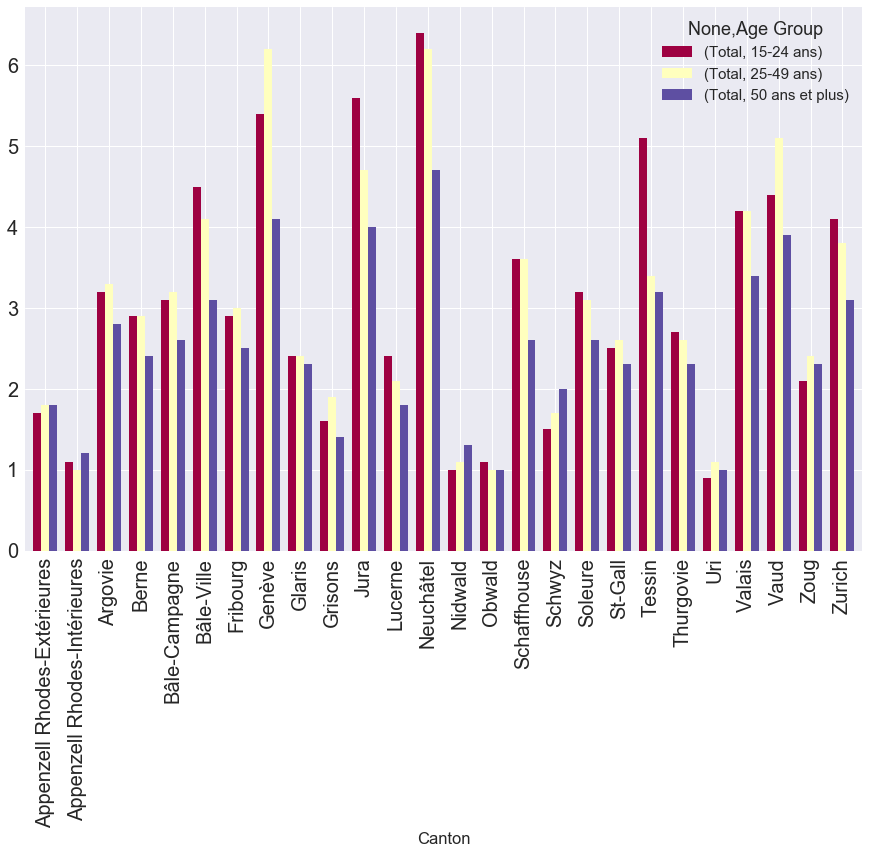

In [590]:
sns.set_style("white");
sns.set_palette(sns.color_palette("hls", 8));
sns.set(font_scale = 1.5);
cmap = cm.get_cmap('Spectral');
plt.figure();
ax = df_CH_age.unstack().plot(kind='bar', figsize=(15, 10), legend=True, fontsize=20, width = 0.75, colormap= cmap);
plt.show()

** DONNEE : Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.**

**QUESTION : Which is a better suited visualization tool for this type of multivariate data? **

## 4. Bonus : Röstigraben

## Unknown

In [325]:
CH_geo = os.path.join('topojson', 'ch-cantons.topojson.json')
geo_json_data = json.load(open(CH_geo))

CH_map.choropleth(
    geo_data=geo_json_data,
    data=df,
    columns=['Canton', 'data_nationality'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate in Switzerland (%)')

#folium.LayerControl().add_to(CH_map)
CH_map

NameError: name 'df' is not defined

In [ ]:
final_df = pd.merge(df_CH_age, df_CH_nationality, on='Canton', how='outer')
final_df.rename(columns={'Juillet 2017_x': 'data_age', 'Juillet 2017_y': 'data_nationality'}, inplace=True)
final_df = final_df.apply(pd.to_numeric, errors='ignore')
#final_df.groupby(["Classes d'âge par étapes de 5 ans", 'Nationalité']).mean()
final_df.loc[final_df.data_age=='...']

In [ ]:
df = final_df.groupby('Canton').mean()
df.reset_index(inplace=True)
df